<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#msticpy---Time-Series-Analysis-and-anomalies-Visualization" data-toc-modified-id="msticpy---Time-Series-Analysis-and-anomalies-Visualization-1">msticpy - Time Series Analysis and anomalies Visualization</a></span></li><li><span><a href="#Generating-Time-Series-Data" data-toc-modified-id="Generating-Time-Series-Data-2">Generating Time Series Data</a></span><ul class="toc-item"><li><span><a href="#Using-LogAnalytics-Query-Provider" data-toc-modified-id="Using-LogAnalytics-Query-Provider-2.1">Using LogAnalytics Query Provider</a></span><ul class="toc-item"><li><span><a href="#Displaying-available-timeseries-queries" data-toc-modified-id="Displaying-available-timeseries-queries-2.1.1">Displaying available timeseries queries</a></span></li><li><span><a href="#Get-TimeSeries-Data-from-LogAnalytics-Table" data-toc-modified-id="Get-TimeSeries-Data-from-LogAnalytics-Table-2.1.2">Get TimeSeries Data from LogAnalytics Table</a></span></li></ul></li></ul></li><li><span><a href="#Time-Series-Analysis-and-discovering-Anomalies" data-toc-modified-id="Time-Series-Analysis-and-discovering-Anomalies-3">Time Series Analysis and discovering Anomalies</a></span><ul class="toc-item"><li><span><a href="#Using-Built-in-KQL-to-generate-TimeSeries-decomposition" data-toc-modified-id="Using-Built-in-KQL-to-generate-TimeSeries-decomposition-3.1">Using Built-in KQL to generate TimeSeries decomposition</a></span></li><li><span><a href="#Using-MSTICPY---Seasonal-Trend-decomposition-using-LOESS-(STL)" data-toc-modified-id="Using-MSTICPY---Seasonal-Trend-decomposition-using-LOESS-(STL)-3.2">Using MSTICPY - Seasonal-Trend decomposition using LOESS (STL)</a></span><ul class="toc-item"><li><span><a href="#Documentation-of-timeseries_anomalies_stl-function" data-toc-modified-id="Documentation-of-timeseries_anomalies_stl-function-3.2.1">Documentation of timeseries_anomalies_stl function</a></span></li><li><span><a href="#Discover-anomalies-using-timeseries_anomalies_stl-function" data-toc-modified-id="Discover-anomalies-using-timeseries_anomalies_stl-function-3.2.2">Discover anomalies using timeseries_anomalies_stl function</a></span></li><li><span><a href="#Displaying-Anomalies-using-STL" data-toc-modified-id="Displaying-Anomalies-using-STL-3.2.3">Displaying Anomalies using STL</a></span></li></ul></li><li><span><a href="#Read-From-External-Sources" data-toc-modified-id="Read-From-External-Sources-3.3">Read From External Sources</a></span><ul class="toc-item"><li><span><a href="#Displaying-Anomalies-Separately" data-toc-modified-id="Displaying-Anomalies-Separately-3.3.1">Displaying Anomalies Separately</a></span></li></ul></li><li><span><a href="#Displaying-Time-Series-anomaly-alerts" data-toc-modified-id="Displaying-Time-Series-anomaly-alerts-3.4">Displaying Time Series anomaly alerts</a></span></li></ul></li><li><span><a href="#Time-Series-Anomalies-Visualization" data-toc-modified-id="Time-Series-Anomalies-Visualization-4">Time Series Anomalies Visualization</a></span><ul class="toc-item"><li><span><a href="#Using-Bokeh-Visualization-Library" data-toc-modified-id="Using-Bokeh-Visualization-Library-4.1">Using Bokeh Visualization Library</a></span></li><li><span><a href="#Documentation-for-display_timeseries_anomalies" data-toc-modified-id="Documentation-for-display_timeseries_anomalies-4.2">Documentation for display_timeseries_anomalies</a></span></li><li><span><a href="#Exporting-Plots-as-PNGs" data-toc-modified-id="Exporting-Plots-as-PNGs-4.3">Exporting Plots as PNGs</a></span></li><li><span><a href="#Using-Built-in-KQL-render-operator" data-toc-modified-id="Using-Built-in-KQL-render-operator-4.4">Using Built-in KQL render operator</a></span></li></ul></li></ul></div>

# msticpy - Time Series Analysis and anomalies Visualization

This notebook demonstrates the time series analysis and anomalies visualization built using the [Bokeh library](https://bokeh.pydata.org) as well as using built-in native KQL operators.

Time Series analysis generally involves below steps
- Generating TimeSeries Data
- Use Time Series Analysis functions to discover anomalies
- Visualize Time Series anomalies

Read more about time series analysis in detail from reference microsoft TechCommunity blog posts

<br>***Reference Blog Posts:***
- [Looking for unknown anomalies - what is normal? Time Series analysis & its applications in Security](https://techcommunity.microsoft.com/t5/azure-sentinel/looking-for-unknown-anomalies-what-is-normal-time-series/ba-p/555052)
- [Time Series visualization of Palo Alto logs to detect data exfiltration](https://techcommunity.microsoft.com/t5/azure-sentinel/time-series-visualization-of-palo-alto-logs-to-detect-data/ba-p/666344)

In [1]:
# Imports
import sys
import warnings

from msticpy.nbtools.utility import check_py_version

MIN_REQ_PYTHON = (3, 6)
check_py_version(MIN_REQ_PYTHON)

from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import pandas as pd

# setting pandas display options for dataframe
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 100)

# msticpy imports
from msticpy.data import QueryProvider
from msticpy.nbtools import *
from msticpy.sectools import *
from msticpy.nbtools.wsconfig import WorkspaceConfig
from msticpy.nbtools.timeseries import display_timeseries_anomolies 
from msticpy.analysis.timeseries import timeseries_anomalies_stl

WIDGET_DEFAULTS = {
    "layout": widgets.Layout(width="95%"),
    "style": {"description_width": "initial"},
}

# Adjusting width of the screen
display(HTML("<style>.container { width:90% !important; }</style>"))

# Generating Time Series Data
Time Series is a series of data points indexed (or listed or graphed) in time order. 
<br>The data points are often discrete numeric points such as frequency of counts or occurrences against a timestamp column of the dataset

## Using LogAnalytics Query Provider
msticpy has QueryProvider through which you can connect to LogAnalytics Data environment. via `QueryProvider(data_environment="LogAnalytics")`
<br>Once you connect to data environment (`qry_prov.connect()`), you can list the available queries (`qry_prov.list_queries()`) for the data environment which in this case is LogAnalytics.

```python
# Read workspace configuration from msticpyconfig.yaml
ws_config = WorkspaceConfig()
# Authentication
qry_prov = QueryProvider(data_environment="LogAnalytics")
qry_prov.connect(connection_str=ws_config.code_connect_str)
```

### Displaying available timeseries queries
For this notebook, we are interested in time series queries only, so we will filter and display only those.

```python
queries = qry_prov.list_queries()
for query in queries:
    if "timeseries" in query:
        print(query)
```

```
MultiDataSource.get_timeseries_anomalies
MultiDataSource.get_timeseries_data
MultiDataSource.get_timeseries_decompose
MultiDataSource.plot_timeseries_datawithbaseline
MultiDataSource.plot_timeseries_scoreanomolies
```

### Get TimeSeries Data from LogAnalytics Table

You can get more details about the individual query by executing  `qry_prov.MultiDataSource.get_timeseries_data('?')` which will display Query, data source, parameters and parameterized raw KQL query 
```
Query:  get_timeseries_data
Data source:  LogAnalytics
Retrieves TimeSeriesData prepared to use with built-in KQL time series functions

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
aggregatecolumn: str (optional)
    field to agregate from source dataset
    (default value is: Total)
aggregatefunction: str (optional)
    Aggregation functions to use - count(), sum(), avg() etc
    (default value is: count())
end: datetime
    Query end time
groupbycolumn: str (optional)
    Group by field to aggregate results
    (default value is: Type)
scorethreshold: str (optional)
    Score threshold for alerting
    (default value is: 3)
start: datetime
    Query start time
table: str
    Table name
timeframe: str (optional)
    Aggregation TimeFrame
    (default value is: 1h)
timestampcolumn: str (optional)
    Timestamp field to use from source dataset
    (default value is: TimeGenerated)
where_clause: str (optional)
    Optional additional filter clauses
Query:
 {table} {where_clause} | project {timestampcolumn},{aggregatecolumn},{groupbycolumn} | where {timestampcolumn} >= datetime({start}) | where {timestampcolumn} <= datetime({end}) | make-series {aggregatecolumn}={aggregatefunction} on {timestampcolumn} from datetime({start}) to datetime({end}) step {timeframe} by {groupbycolumn} {add_query_items}
```

***Sample python code leveraging KQL query will look like this***

```python

# Specify start and end timestamps
start = "2020-02-09 00:00:00.000000"
end = "2020-03-10 00:00:00.000000"

# Execute the query by passing required and optional parameters
time_series_data = qry_prov.MultiDataSource.get_timeseries_data(
    start=start,
    end=end,
    table="CommonSecurityLog",
    timestampcolumn="TimeGenerated",
    aggregatecolumn="SentBytes",
    groupbycolumn="DeviceVendor",
    aggregatefunction="sum(SentBytes)",
    where_clause='|where DeviceVendor=="Palo Alto Networks"',
    add_query_items='|mv-expand TimeGenerated to typeof(datetime), SentBytes to typeof(long)',
    )

 #display output
time_series_data
```

# Time Series Analysis and discovering Anomalies
By analyzing time series data over an extended period, we can identify time-based patterns (e.g. seasonality, trend etc.) in the data and extract meaningful statistics which can help in flagging outliers.  A particular example in a security context is user logon patterns over a period of time exhibiting different behavior after hours and on weekends: computing deviations from these changing patterns is rather difficult in traditional atomic detections with static thresholds. KQL built-in functions can automatically identify such seasonality and trend from the input data and take it into consideration when flagging anomalies.

## Using Built-in KQL to generate TimeSeries decomposition
In this case, we will use built-in KQL function `series_decompose()` to decompose time series to generate additional data points such as baseline, seasonal , trend etc.

***KQL Reference Documentation:***
- [series_decompose](https://docs.microsoft.com/en-us/azure/kusto/query/series-decomposefunction)

You can use available query `qry_prov.MultiDataSource.get_timeseries_decompose()` to get the similar details
```
Query:  get_timeseries_decompose
Data source:  LogAnalytics
Time Series decomposition and anomalies generated using built-in KQL time series function- series_decompose

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
aggregatecolumn: str (optional)
    field to agregate from source dataset
    (default value is: Total)
aggregatefunction: str (optional)
    Aggregation functions to use - count(), sum(), avg() etc
    (default value is: count())
end: datetime
    Query end time
groupbycolumn: str (optional)
    Group by field to aggregate results
    (default value is: Type)
scorethreshold: str (optional)
    Score threshold for alerting
    (default value is: 3)
start: datetime
    Query start time
table: str
    Table name
timeframe: str (optional)
    Aggregation TimeFrame
    (default value is: 1h)
timestampcolumn: str (optional)
    Timestamp field to use from source dataset
    (default value is: TimeGenerated)
where_clause: str (optional)
    Optional additional filter clauses
Query:
 {table} {where_clause} | project {timestampcolumn},{aggregatecolumn},{groupbycolumn} | where {timestampcolumn} >= datetime({start}) | where {timestampcolumn} <= datetime({end}) | make-series {aggregatecolumn}={aggregatefunction} on {timestampcolumn} from datetime({start}) to datetime({end}) step {timeframe} by {groupbycolumn} | extend (baseline,seasonal,trend,residual) = series_decompose({aggregatecolumn}) | mv-expand {aggregatecolumn} to typeof(double), {timestampcolumn} to typeof(datetime), baseline to typeof(double), seasonal to typeof(double), trend to typeof(long), residual to typeof(long) {add_query_items}
```

***Sample python code leveraging KQL query will look like this***

```python
time_series_baseline = qry_prov.MultiDataSource.get_timeseries_decompose(
    start=start,
    end=end,
    table="CommonSecurityLog",
    timestampcolumn="TimeGenerated",
    aggregatecolumn="SentBytes",
    groupbycolumn="DeviceVendor",
    aggregatefunction="sum(SentBytes)",
    where_clause='|where DeviceVendor=="Palo Alto Networks"',
)

#Show sample records
time_series_baseline.head()
```

## Using MSTICPY - Seasonal-Trend decomposition using LOESS (STL)

In this case, we will use function msticpy function `timeseries_anomalies_stl` which leverages `STL` method from `statsmodels` API to decompose a time series into three components: trend, seasonal and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. The key inputs into STL are:

- season - The length of the seasonal smoother. Must be odd.
- trend - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.
- low_pass - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.

More info : https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL


### Documentation of timeseries_anomalies_stl function

timeseries_anomalies_stl(data: pandas.core.frame.DataFrame, **kwargs) -> pandas.core.frame.DataFrame
    Discover anomalies in Timeseries data using
    STL (Seasonal-Trend Decomposition using LOESS) method using statsmodels package.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame as a time series data set retrived from data connector or external data source.
        Dataframe must have 2 columns with time column set as index and other numeric value.
    
    Other Parameters
    ----------------
    seasonal : int, optional
        Seasonality period of the input data required for STL. 
        Must be an odd integer, and should normally be >= 7 (default).
    period: int, optional
        Periodicity of the the input data. by default 24 (Hourly).
    score_threshold : float, optional
        standard deviation threshold value calculated using Z-score used to flag anomalies,
        by default 3
    
    Returns
    -------
    pd.DataFrame
        Returns a dataframe with additional columns by decomposing time series data
        into residual, trend, seasonal, weights, baseline, score and anomalies.
        The anomalies column will have 0, 1,-1 values based on score_threshold set.


In [2]:
# Read Time series data with date as index and other column
stldemo = pd.read_csv(
    "data/TimeSeriesDemo.csv", index_col=["TimeGenerated"], usecols=["TimeGenerated","TotalBytesSent"])
stldemo.head()

TotalBytesSent
TimeGenerated                       
2019-05-01T06:00:00Z       873713587
2019-05-01T07:00:00Z       882187669
2019-05-01T08:00:00Z       852506841
2019-05-01T09:00:00Z       898793650
2019-05-01T10:00:00Z       891598085

### Discover anomalies using timeseries_anomalies_stl function
We will run msticpy function `timeseries_anomalies_stl` on the input data to discover anomalies.

In [3]:
output = timeseries_anomalies_stl(stldemo)
output.head()

TimeGenerated  TotalBytesSent  residual      trend  seasonal  \
0  2019-05-01T06:00:00Z       873713587  -7258970  786685528  94287029   
1  2019-05-01T07:00:00Z       882187669   2291183  789268398  90628087   
2  2019-05-01T08:00:00Z       852506841  -2875384  791851068  63531157   
3  2019-05-01T09:00:00Z       898793650  17934415  794432848  86426386   
4  2019-05-01T10:00:00Z       891598085   8677706  797012590  85907788   

   weights   baseline     score  anomalies  
0        1  880972557 -0.097114          0  
1        1  879896485  0.029661          0  
2        1  855382225 -0.038923          0  
3        1  880859234  0.237320          0  
4        1  882920378  0.114440          0

### Displaying Anomalies using STL
We will filter only the anomalies (with value 1 from anomalies column) of the output dataframe retrieved after running the msticpy function `timeseries_anomalies_stl`

In [4]:
output[output['anomalies']==1]

TimeGenerated  TotalBytesSent   residual       trend   seasonal  \
299  2019-05-13T17:00:00Z       916767394  288355070   523626111  104786212   
399  2019-05-17T21:00:00Z      1555286702  296390627  1132354860  126541214   
599  2019-05-26T05:00:00Z      1768911488  347810809  1300005332  121095345   

     weights    baseline     score  anomalies  
299        1   628412323  3.827062          1  
399        1  1258896074  3.933731          1  
599        1  1421100678  4.616317          1

## Read From External Sources
If you have time series data in other locations, you can read it via pandas or respective data store API where data is stored. The pandas I/O API is a set of top level reader functions accessed like pandas.read_csv() that generally return a pandas object.

Read More at Pandas Documentation:
- [I/O Tools (Text ,CSV,HDF5..)](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html)

Example of using Pandas `read_csv` to read local csv file containing TimeSeries demo dataset. Additional columns in the csv such as `baseline`, `score` and `anoamlies` are generated using built-in KQL Time series functions such as `series_decompose_anomalies()`.

In [5]:
timeseriesdemo = pd.read_csv(
    "data/TimeSeriesDemo.csv", parse_dates=["TimeGenerated"], infer_datetime_format=True
)

#show sample records
timeseriesdemo.head()

TimeGenerated  TotalBytesSent   baseline     score  anomalies
0 2019-05-01 06:00:00       873713587  782728212  0.224776          0
1 2019-05-01 07:00:00       882187669  838492449  0.000000          0
2 2019-05-01 08:00:00       852506841  816772273  0.000000          0
3 2019-05-01 09:00:00       898793650  878871426  0.000000          0
4 2019-05-01 10:00:00       891598085  862639955  0.000000          0

### Displaying Anomalies Separately
We will filter only the anomalies shown in the above plot and display below along with associated aggreageted hourly timewindow. You can later query for the time windows scope for additional alerts triggered or any other suspicious activity from other datasources.

In [6]:
#Filtering anomales column for 1 and displaying records
timeseriesdemo[timeseriesdemo['anomalies'] == 1].reset_index()

index       TimeGenerated  TotalBytesSent    baseline     score  anomalies
0    299 2019-05-13 17:00:00       916767394   662107538  3.247957          1
1    399 2019-05-17 21:00:00      1555286702  1212399509  4.877577          1
2    599 2019-05-26 05:00:00      1768911488  1391114419  5.522387          1

## Displaying Time Series anomaly alerts

You can also use `series_decompose_anomalies()` which will run Anomaly Detection based on series decomposition. This takes an expression containing a series (dynamic numerical array) as input and extract anomalous points with scores.

***KQL Reference Documentation:***
- [series_decompose_anomalies](https://docs.microsoft.com/en-us/azure/kusto/query/series-decompose-anomaliesfunction)

You can use available query `qry_prov.MultiDataSource.get_timeseries_alerts()` to get the similar details
```
Query:  get_timeseries_anomalies
Data source:  LogAnalytics
Time Series anomalies detected using built-in KQL time series function-series_decompose_anomalies

Parameters
----------
add_query_items: str (optional)
    Additional query clauses
aggregatecolumn: str (optional)
    field to agregate from source dataset
    (default value is: Total)
aggregatefunction: str (optional)
    Aggregation functions to use - count(), sum(), avg() etc
    (default value is: count())
end: datetime
    Query end time
groupbycolumn: str (optional)
    Group by field to aggregate results
    (default value is: Type)
scorethreshold: str (optional)
    Score threshold for alerting
    (default value is: 3)
start: datetime
    Query start time
table: str
    Table name
timeframe: str (optional)
    Aggregation TimeFrame
    (default value is: 1h)
timestampcolumn: str (optional)
    Timestamp field to use from source dataset
    (default value is: TimeGenerated)
where_clause: str (optional)
    Optional additional filter clauses
Query:
 {table} {where_clause} | project {timestampcolumn},{aggregatecolumn},{groupbycolumn} | where {timestampcolumn} >= datetime({start}) | where {timestampcolumn} <= datetime({end}) | make-series {aggregatecolumn}={aggregatefunction} on {timestampcolumn} from datetime({start}) to datetime({end}) step {timeframe} by {groupbycolumn} | extend (anomalies, score, baseline) = series_decompose_anomalies({aggregatecolumn}, {scorethreshold},-1,"linefit") | mv-expand {aggregatecolumn} to typeof(double), {timestampcolumn} to typeof(datetime), anomalies to typeof(double), score to typeof(double), baseline to typeof(long) | extend score = round(score,2) {add_query_items}
```

***Sample python code leveraging KQL query will look like this***

```python

# Specify start and end timestamps
start = "2020-02-09 00:00:00.000000"
end = "2020-03-10 00:00:00.000000"

# Execute the query by passing required and optional parameters. you can also add add_query_items='|where anomalies>0' to filter and show only anomalies, else it will show all records.
time_series_anomalies = qry_prov.MultiDataSource.get_timeseries_anomalies(
    start=start,
    end=end,
    table="CommonSecurityLog",
    timestampcolumn="TimeGenerated",
    aggregatecolumn="SentBytes",
    groupbycolumn="DeviceVendor",
    aggregatefunction="sum(SentBytes)",
    where_clause='|where DeviceVendor=="Palo Alto Networks"',
    scorethreshold='1.5',
    )

#display output
time_series_anomalies
```

# Time Series Anomalies Visualization
Time series anomalies once discovered, you can visualize with line chart type to display outliers.
Below we will see 2 types to visualize, using msticpy function `display_timeseries_anomalies()` via Bokeh library as well as using built-in KQL `render` operator.

## Using Bokeh Visualization Library

## Documentation for display_timeseries_anomalies
```
display_timeseries_anomolies(
    data: pandas.core.frame.DataFrame,
    y: str = 'Total',
    time_column: str = 'TimeGenerated',
    anomalies_column: str = 'anomalies',
    source_columns: list = None,
    period: int = 30,
    **kwargs,
) -> <function figure at 0x7f0de9ae2598>
Docstring:
Display time series anomalies visualization

Parameters
----------
data : pd.DataFrame
    DataFrame as a time series data set retreived from KQL time series functions
    dataframe will have columns as TimeGenerated, y, baseline, score, anomalies

Other Parameters
----------------
y : str, optional
    Name of column holding numeric values to plot against time series to determine anomolies
    (the default is 'Total')
time_column : str, optional
    Name of the timestamp column
    (the default is 'TimeGenerated')
anomolies_column : str, optional
    Name of the column holding binary status(1/0) for anomaly/benign
    (the default is 'anomolies')
ref_time : datetime, optional
    Input reference line to display (the default is None)
title : str, optional
    Title to display (the default is None)
legend: str, optional
    Where to position the legend
    None, left, right or inline (default is None)
yaxis : bool, optional
    Whether to show the yaxis and labels
range_tool : bool, optional
    Show the the range slider tool (default is True)
source_columns : list, optional
    List of default source columns to use in tooltips
    (the default is None)
height : int, optional
    The height of the plot figure
    (the default is auto-calculated height)
width : int, optional
    The width of the plot figure (the default is 900)
xgrid : bool, optional
        Whether to show the xaxis grid (default is True)
ygrid : bool, optional
        Whether to show the yaxis grid (default is False)
color : list, optional
        List of colors to use in 3 plots as specified in order 
        3 plots- line(observed), circle(baseline), circle_x/user specified(anomalies).
        (the default is ["navy", "green", "firebrick"])

Returns
-------
figure
    The bokeh plot figure.
```

In [7]:
timeseries_anomalies_plot = display_timeseries_anomolies(data=timeseriesdemo, y="TotalBytesSent");

Loading BokehJS ...

## Exporting Plots as PNGs
To use bokeh.io image export functions you need selenium, phantomjs and pillow installed:

`conda install -c bokeh selenium phantomjs pillow`

or

`pip install selenium pillow`
`npm install -g phantomjs-prebuilt`

For phantomjs see https://phantomjs.org/download.html.

Once the prerequisites are installed you can create a plot and save the return value to a variable. 
Then export the plot using `export_png` function.

***Sample code to export png***

```python
from bokeh.io import export_png
from IPython.display import Image

# Create a plot
timeseries_anomaly_plot = display_timeseries_anomolies(
    data=timeseriesdemo, y="TotalBytesSent"
)

# Export
file_name = "plot.png"
export_png(timeseries_anomaly_plot, filename=file_name)

# Read it and show it
display(Markdown(f"## Here is our saved plot: {file_name}"))
Image(filename=file_name)
```

## Using Built-in KQL render operator
Render operator instructs the user agent to render the results of the query in a particular way. In this case, we are using timechart which will display linegraph.

***KQL Reference Documentation:***
- [render](https://docs.microsoft.com/en-us/azure/kusto/query/renderoperator?pivots=azuremonitor)

***sample python code with KQL query leveraging render operator on time series data will look like below***
```python
timechartquery = """
let TimeSeriesData = PaloAltoTimeSeriesDemo_CL
| extend TimeGenerated = todatetime(EventTime_s), TotalBytesSent = todouble(TotalBytesSent_s) 
| summarize TimeGenerated=make_list(TimeGenerated, 10000),TotalBytesSent=make_list(TotalBytesSent, 10000) by deviceVendor_s
| project TimeGenerated, TotalBytesSent;
TimeSeriesData
| extend (baseline,seasonal,trend,residual) = series_decompose(TotalBytesSent)
| mv-expand TotalBytesSent to typeof(double), TimeGenerated to typeof(datetime), baseline to typeof(long), seasonal to typeof(long), trend to typeof(long), residual to typeof(long)
| project TimeGenerated, TotalBytesSent, baseline
| render timechart with (title="Palo Alto Outbound Data Transfer Time Series decomposition")
"""
%kql -query timechartquery
```

***Rendered output for the above code look like below image***

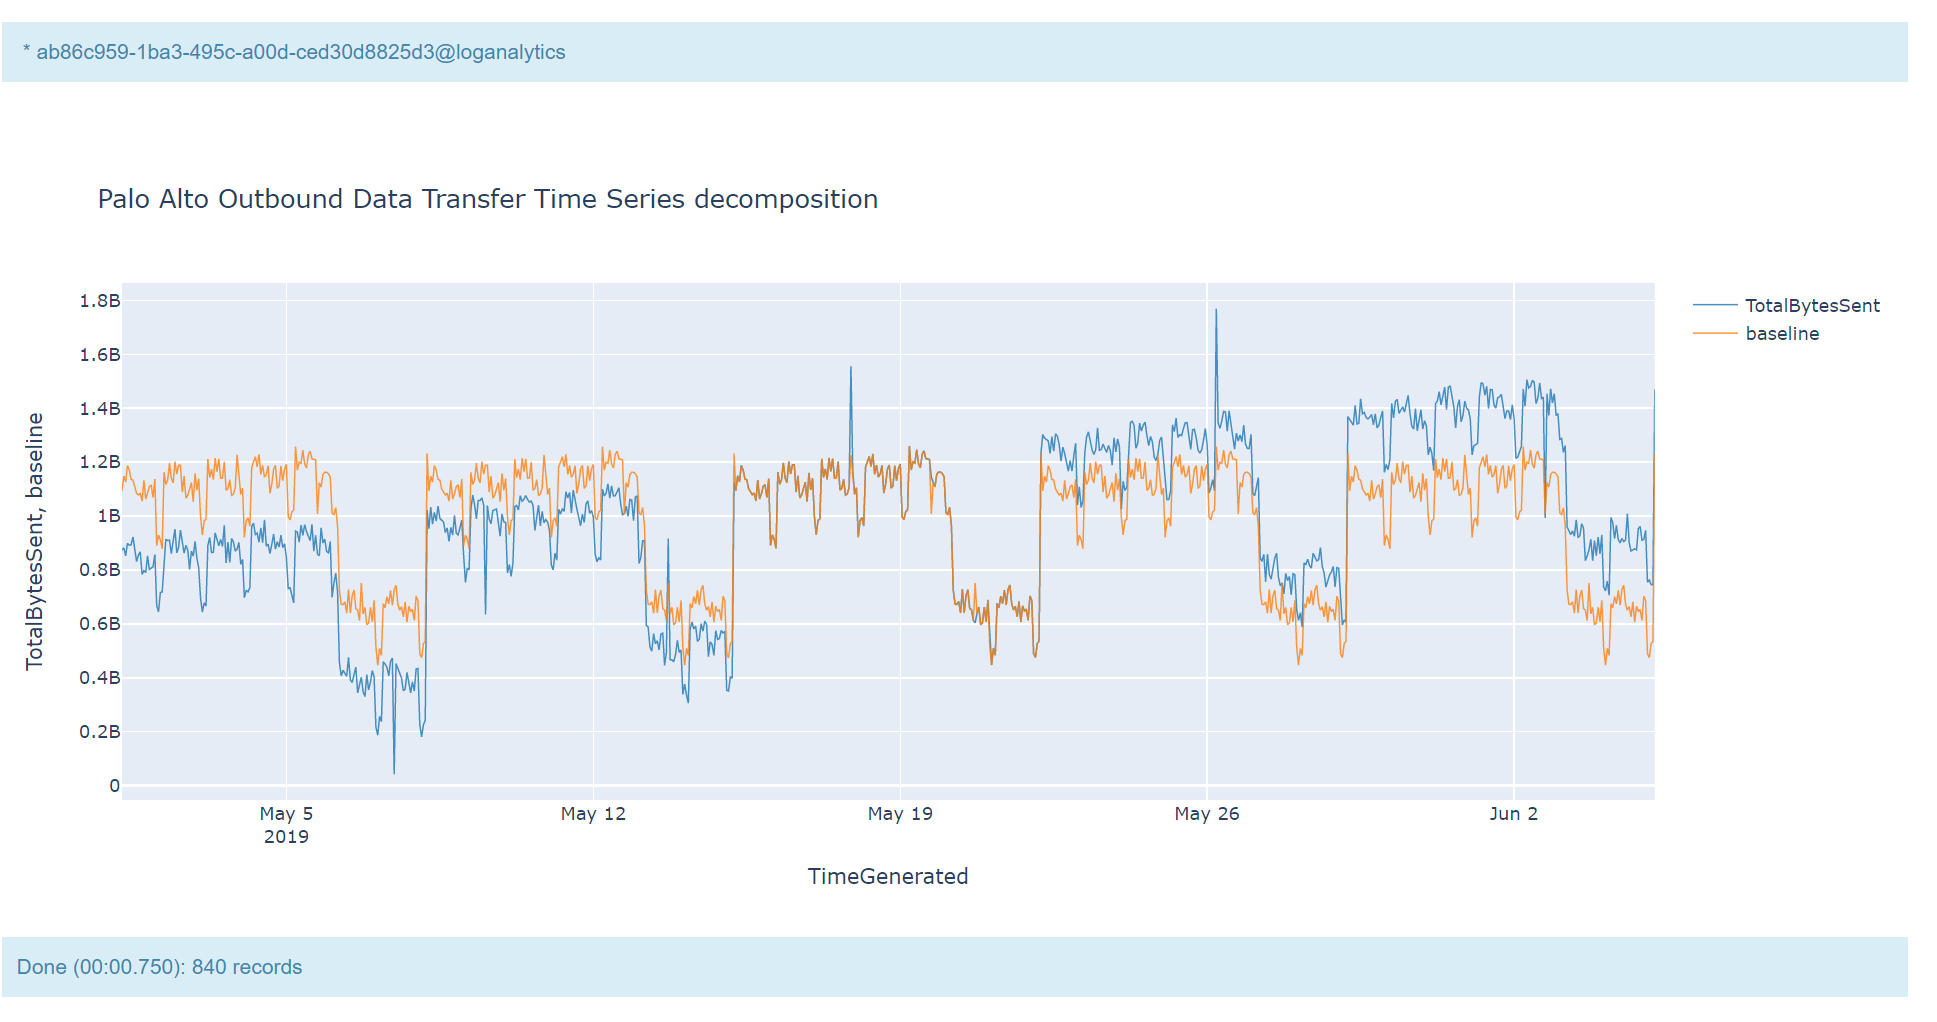